### LSTM para clasificación de Pacientes con Enfermedad de Parkinson en marcha, voz, y escritura

In [58]:
from six.moves import cPickle as pickle
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np

## carga la base de datos de marcha

In [207]:
pickle_file = 'Gait_STFT.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    x_train = save['train_dataset']
    y_train = save['train_labels']
    x_valid = save['valid_dataset']
    y_valid = save['valid_labels']
    x_test = save['test_dataset']
    y_test = save['test_labels']
    del save  # hint to help gc free up memory



def reformat2(dataset, labels):
    dataset = dataset.reshape((-1, dataset.shape[1], dataset.shape[2])).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    #labels = (np.arange(2) == labels[:,None]).astype(np.float32)
    return dataset, labels


x_train, y_train = reformat2(x_train, y_train)
x_valid, y_valid = reformat2(x_valid, y_valid)
x_test, y_test = reformat2(x_test, y_test)
print('Training set', x_train.shape, y_train.shape)
print('Validation set', x_valid.shape, y_valid.shape)
print('Test set', x_test.shape, y_test.shape)

Training set (1206, 150, 225) (1206, 2)
Validation set (134, 150, 225) (134, 2)
Test set (148, 150, 225) (148, 2)


## Defino arquitectura de la red



In [223]:
HIDDEN_UNITS=128
input_shape = (x_train.shape[1], x_train.shape[2])
num_labels=2


model = Sequential()
model.add(LSTM(HIDDEN_UNITS, input_shape=input_shape))
model.add(Dense(num_labels, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 128)               181248    
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 258       
Total params: 181,506.0
Trainable params: 181,506
Non-trainable params: 0.0
_________________________________________________________________


## Entreno la red

In [224]:
NUM_EPOCHS=50
BATCH_SIZE=64
%time history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/50
1206/1206 [==============================] - 28s - loss: 0.6986 - acc: 0.6045    
Epoch 2/50
1206/1206 [==============================] - 23s - loss: 0.5203 - acc: 0.7446    
Epoch 3/50
1206/1206 [==============================] - 22s - loss: 0.4312 - acc: 0.7902    
Epoch 4/50
1206/1206 [==============================] - 23s - loss: 0.3549 - acc: 0.8433    
Epoch 5/50
1206/1206 [==============================] - 23s - loss: 0.3212 - acc: 0.8665    
Epoch 6/50
1206/1206 [==============================] - 26s - loss: 0.2791 - acc: 0.8765    
Epoch 7/50
1206/1206 [==============================] - 26s - loss: 0.2651 - acc: 0.8814    
Epoch 8/50
1206/1206 [==============================] - 32s - loss: 0.2313 - acc: 0.8947    
Epoch 9/50
1206/1206 [==============================] - 28s - loss: 0.2066 - acc: 0.9104    
Epoch 10/50
1206/1206 [==============================] - 30s - loss: 0.2055 - acc: 0.9138    
Epoch 11/50
1206/1206 [==============================] - 28s - loss: 

dict_keys(['loss', 'acc'])


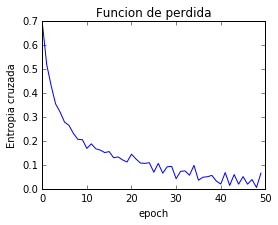

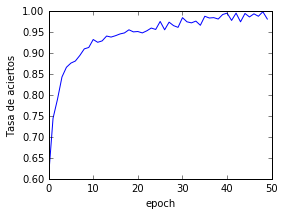

In [225]:
# list all data in history
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
                
    
# summarize history for loss
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'])
plt.title('Funcion de perdida')
plt.ylabel('Entropia cruzada')
plt.xlabel('epoch')
plt.savefig('lossGaitLSTM.pdf')
plt.show()

plt.figure(figsize=(4,3))
plt.plot(history.history['acc'])
plt.ylabel('Tasa de aciertos')
plt.xlabel('epoch')
plt.savefig('accLSTM.pdf')
plt.show()



In [226]:
from sklearn.metrics import confusion_matrix
import itertools

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])




def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')



(148, 2)
accuracy en conjunto de test= 95.2702702703
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.08  0.92]]


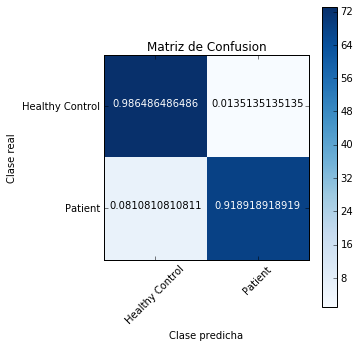

In [227]:

label_predGait = model.predict(x_test)
print (label_predGait.shape)


accTest=accuracy(label_predGait, y_test)

print('accuracy en conjunto de test=', accTest)

# grafica de la matriz de confusion

cnf_matrix = confusion_matrix(np.argmax(label_predGait,1), np.argmax(y_test,1))
np.set_printoptions(precision=2)

class_names=['Healthy Control', 'Patient']
# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matriz de Confusion')

plt.savefig('cmGaitLSTM.pdf')
plt.show()

## carga la base de datos de voz: Onset

In [246]:
pickle_file = 'onset150PCGITAddk.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    ID = save['ID']
    y = save['labelclass']
    x = save['stft']
    task = save['Task']
    del save  # hint to help gc free up memory



y2 = np_utils.to_categorical(y, 2)
print(x.shape, y.shape)

(8072, 65, 49) (8072,)


In [247]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
group_kfold = GroupKFold(n_splits=10)

skf=StratifiedKFold(n_splits=10, shuffle=True)

p=np.random.permutation(len(ID))

x=x[p,:,:]
y=y[p]
y2=y2[p,:]
ID=ID[p]
task=[task[i] for i in p]

for train_index, test_index in group_kfold.split(x, y,ID):
    print(len(train_index), len(test_index))
    break
    
print(np.unique(ID[test_index]))

x_train=x[train_index,:,:]
y_train=y2[train_index,:]
x_test=x[test_index,:,:]
y_test=y2[test_index,:]

avg_image=np.mean(x_train,0)
std_image=np.std(x_train,0)

x_train=(x_train-avg_image)/std_image
x_test=(x_test-avg_image)/std_image

7259 813
[18 23 34 38 41 42 78 85 89 97]


In [248]:
from keras.optimizers import RMSprop

HIDDEN_UNITS=128
input_shape = (x_train.shape[1], x_train.shape[2])
num_labels=2


model2 = Sequential()
model2.add(LSTM(HIDDEN_UNITS, input_shape=input_shape, dropout=0.5))
#model2.add(Dropout(0.5))
model2.add(Dense(num_labels, activation='softmax'))
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#optimizer = RMSprop(lr=0.01)
#model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 128)               91136     
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 258       
Total params: 91,394.0
Trainable params: 91,394
Non-trainable params: 0.0
_________________________________________________________________


In [249]:
NUM_EPOCHS=50
BATCH_SIZE=64
%time history = model2.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1, validation_data=(x_test, y_test))

Train on 7259 samples, validate on 813 samples
Epoch 1/50
7259/7259 [==============================] - 56s - loss: 0.6575 - acc: 0.5991 - val_loss: 0.7084 - val_acc: 0.6962
Epoch 2/50
7259/7259 [==============================] - 51s - loss: 0.6476 - acc: 0.6128 - val_loss: 0.6613 - val_acc: 0.5326
Epoch 3/50
7259/7259 [==============================] - 50s - loss: 0.6390 - acc: 0.6279 - val_loss: 0.6657 - val_acc: 0.6679
Epoch 4/50
7259/7259 [==============================] - 51s - loss: 0.6360 - acc: 0.6319 - val_loss: 0.6906 - val_acc: 0.5732
Epoch 5/50
7259/7259 [==============================] - 50s - loss: 0.6273 - acc: 0.6384 - val_loss: 0.6926 - val_acc: 0.4982
Epoch 6/50
7259/7259 [==============================] - 51s - loss: 0.6166 - acc: 0.6501 - val_loss: 0.7750 - val_acc: 0.5572
Epoch 7/50
7259/7259 [==============================] - 50s - loss: 0.6112 - acc: 0.6647 - val_loss: 0.6962 - val_acc: 0.5633
Epoch 8/50
7259/7259 [==============================] - 49s - loss: 0.5

(813, 2)
accuracy en conjunto de test= 50.6765067651
Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.71  0.29]]


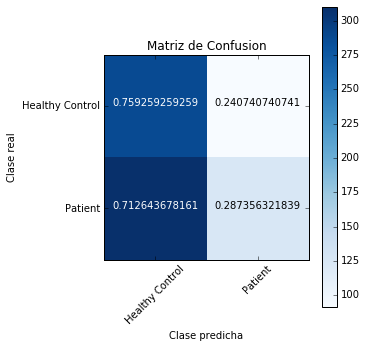

In [250]:

label_predGait = model2.predict(x_test)
print (label_predGait.shape)


accTest=accuracy(label_predGait, y_test)

print('accuracy en conjunto de test=', accTest)

# grafica de la matriz de confusion

cnf_matrix = confusion_matrix(np.argmax(label_predGait,1), np.argmax(y_test,1))
np.set_printoptions(precision=2)

class_names=['Healthy Control', 'Patient']
# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matriz de Confusion')

plt.savefig('cmSpeechLSTM.pdf')
plt.show()

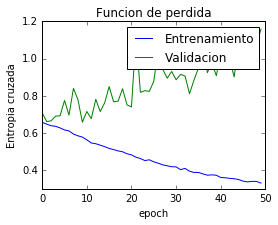

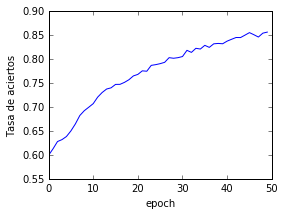

In [251]:
# summarize history for loss
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida')
plt.ylabel('Entropia cruzada')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'Validacion'])
plt.savefig('lossspeechLSTM.pdf')
plt.show()

plt.figure(figsize=(4,3))
plt.plot(history.history['acc'])
plt.ylabel('Tasa de aciertos')
plt.xlabel('epoch')
plt.savefig('accspeechLSTM.pdf')
plt.show()


## Carga la base de datos de escritura: Onset

In [172]:
pickle_file = 'onsethandwritingAll.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    ID = save['ID']
    y = save['labelclass']
    x = save['img']
    task = save['Task']
    del save  # hint to help gc free up memory



y2 = np_utils.to_categorical(y, 2)
print(x.shape, y.shape)

(20977, 36, 16) (20977,)


In [173]:
group_kfold = GroupKFold(n_splits=10)

skf=StratifiedKFold(n_splits=10, shuffle=True)

p=np.random.permutation(len(ID))

x=x[p,:,:]
y=y[p]
y2=y2[p,:]
ID=ID[p]
task=[task[i] for i in p]

for train_index, test_index in group_kfold.split(x, y,ID):
    print(len(train_index), len(test_index))
    break
    
print(np.unique(ID[test_index]))

x_train=x[train_index,:,:]
y_train=y2[train_index,:]
x_test=x[test_index,:,:]
y_test=y2[test_index,:]

avg_image=np.mean(x_train,0)
std_image=np.std(x_train,0)

x_train=(x_train-avg_image)/std_image
x_test=(x_test-avg_image)/std_image

18972 2005
[17 20 36 38 47 70 72]


In [182]:
HIDDEN_UNITS=128
input_shape = (x_train.shape[1], x_train.shape[2])
num_labels=2


model3 = Sequential()
model3.add(LSTM(HIDDEN_UNITS, input_shape=input_shape, dropout=0.5))
#model2.add(Dropout(0.5))
model3.add(Dense(num_labels, activation='softmax'))
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#optimizer = RMSprop(lr=0.01)
#model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 258       
Total params: 74,498.0
Trainable params: 74,498
Non-trainable params: 0.0
_________________________________________________________________


In [183]:
NUM_EPOCHS=50
BATCH_SIZE=64
%time history = model3.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1, validation_data=(x_test, y_test))

Train on 18972 samples, validate on 2005 samples
Epoch 1/50
18972/18972 [==============================] - 142s - loss: 0.5514 - acc: 0.7148 - val_loss: 0.4375 - val_acc: 0.7970
Epoch 2/50
18972/18972 [==============================] - 118s - loss: 0.5121 - acc: 0.7471 - val_loss: 0.4490 - val_acc: 0.7925
Epoch 3/50
18972/18972 [==============================] - 119s - loss: 0.4997 - acc: 0.7583 - val_loss: 0.4363 - val_acc: 0.8070
Epoch 4/50
18972/18972 [==============================] - 118s - loss: 0.4868 - acc: 0.7659 - val_loss: 0.4142 - val_acc: 0.8105
Epoch 5/50
18972/18972 [==============================] - 117s - loss: 0.4811 - acc: 0.7692 - val_loss: 0.4236 - val_acc: 0.8020
Epoch 6/50
18972/18972 [==============================] - 119s - loss: 0.4745 - acc: 0.7736 - val_loss: 0.4097 - val_acc: 0.8185
Epoch 7/50
18972/18972 [==============================] - 117s - loss: 0.4652 - acc: 0.7785 - val_loss: 0.4265 - val_acc: 0.8065
Epoch 8/50
18972/18972 [========================

(2005, 2)
accuracy en conjunto de test= 82.0947630923
Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.16  0.84]]


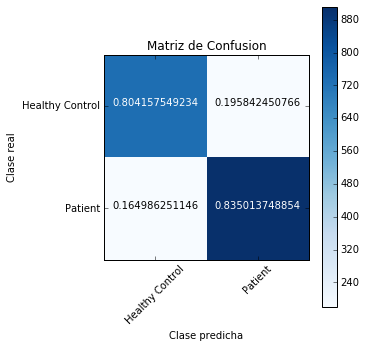

In [184]:

label_predGait = model3.predict(x_test)
print (label_predGait.shape)


accTest=accuracy(label_predGait, y_test)

print('accuracy en conjunto de test=', accTest)

# grafica de la matriz de confusion

cnf_matrix = confusion_matrix(np.argmax(label_predGait,1), np.argmax(y_test,1))
np.set_printoptions(precision=2)

class_names=['Healthy Control', 'Patient']
# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matriz de Confusion')

plt.savefig('cmhandwritingLSTM.pdf')
plt.show()

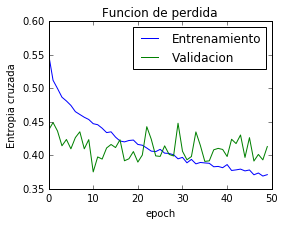

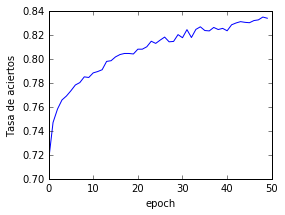

In [185]:
# summarize history for loss
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida')
plt.ylabel('Entropia cruzada')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'Validacion'])
plt.savefig('losshandwritingLSTM.pdf')
plt.show()

plt.figure(figsize=(4,3))
plt.plot(history.history['acc'])
plt.ylabel('Tasa de aciertos')
plt.xlabel('epoch')
plt.savefig('acchandwritingLSTM.pdf')
plt.show()
